In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable


from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [2]:
data_dir = 'E:/temp/render/pgdFont_v01/train/'
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

)


In [4]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [5]:
epochs = 10
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'aerialmodel.pth')        
        

Epoch 1/10.. Train loss: 3.317.. Test loss: 2.065.. Test accuracy: 0.394
Epoch 1/10.. Train loss: 1.708.. Test loss: 1.498.. Test accuracy: 0.489
Epoch 1/10.. Train loss: 1.094.. Test loss: 1.120.. Test accuracy: 0.666
Epoch 1/10.. Train loss: 0.793.. Test loss: 1.270.. Test accuracy: 0.523
Epoch 1/10.. Train loss: 0.623.. Test loss: 0.835.. Test accuracy: 0.695
Epoch 1/10.. Train loss: 0.456.. Test loss: 0.663.. Test accuracy: 0.768
Epoch 1/10.. Train loss: 0.506.. Test loss: 0.329.. Test accuracy: 0.909
Epoch 1/10.. Train loss: 0.471.. Test loss: 0.267.. Test accuracy: 0.925
Epoch 1/10.. Train loss: 0.330.. Test loss: 0.213.. Test accuracy: 0.947
Epoch 1/10.. Train loss: 0.291.. Test loss: 0.153.. Test accuracy: 0.966
Epoch 1/10.. Train loss: 0.215.. Test loss: 0.143.. Test accuracy: 0.967
Epoch 2/10.. Train loss: 0.284.. Test loss: 0.199.. Test accuracy: 0.939
Epoch 2/10.. Train loss: 0.233.. Test loss: 0.130.. Test accuracy: 0.968
Epoch 2/10.. Train loss: 0.263.. Test loss: 0.138..

Epoch 10/10.. Train loss: 0.142.. Test loss: 0.057.. Test accuracy: 0.982


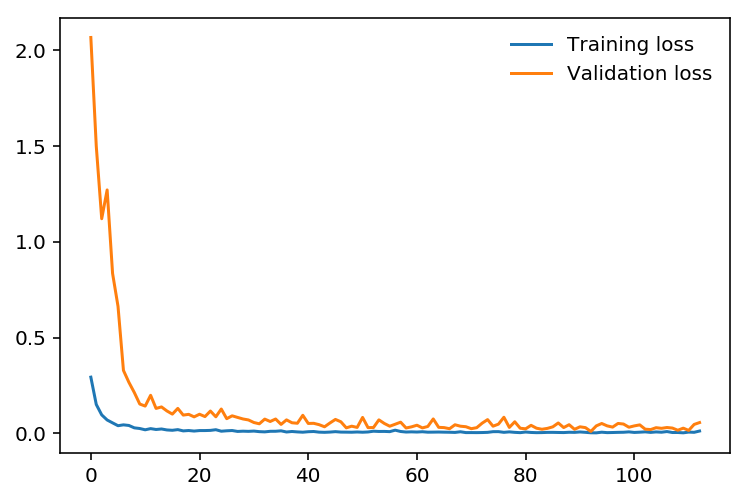

In [6]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [7]:
test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('aerialmodel.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [9]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [10]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

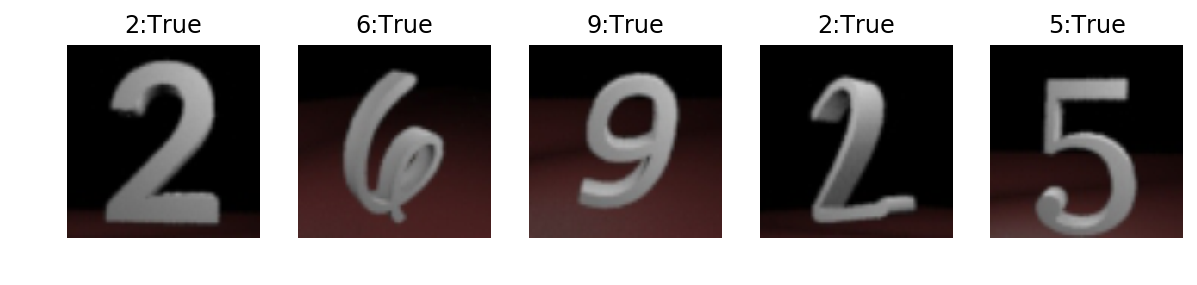

In [11]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
     image = to_pil(images[ii])
     index = predict_image(image)
     sub = fig.add_subplot(1, len(images), ii+1)
     res = int(labels[ii]) == index
     sub.set_title(str(index) + ":" + str(res))
     plt.axis('off')
     plt.imshow(image)
plt.show()